IMPORTACION DE MODULOS

In [36]:
import pandas as pd
from matplotlib import pyplot
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

IMPORTACION DE DATOS


In [37]:
rankings = pd.read_csv('/content/fifa_ranking.csv')
matches = pd.read_csv('/content/results.csv')
copa_america = pd.read_csv('/content/Copa_America_Dataset.csv')

In [38]:
matches

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...,...
42079,2021-03-31,Andorra,Hungary,1,4,FIFA World Cup qualification,Andorra la Vella,Andorra,False
42080,2021-03-31,San Marino,Albania,0,2,FIFA World Cup qualification,Serravalle,San Marino,False
42081,2021-03-31,Armenia,Romania,3,2,FIFA World Cup qualification,Yerevan,Armenia,False
42082,2021-03-31,Germany,North Macedonia,1,2,FIFA World Cup qualification,Duisburg,Germany,False


In [39]:
rankings

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
3,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
4,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57788,206,Anguilla,AIA,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONCACAF,2018-06-07
57789,206,Bahamas,BAH,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONCACAF,2018-06-07
57790,206,Eritrea,ERI,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,2018-06-07
57791,206,Somalia,SOM,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,2018-06-07


In [40]:
copa_america

,Team,Group,First match against,Second match against,Third match against,Fourth match against,Previous titles,Previous finals,Unnamed: 8
0,Argentina,A,Chile,Uruguay,Paraguay,Bolivia,14,28,NaN
1,Bolivia,A,Paraguay,Chile,Uruguay,Argentina,1,2,NaN
2,Uruguay,A,Argentina,Chile,Bolivia,Paraguay,15,21,NaN
3,Chile,A,Argentina,Bolivia,Uruguay,Paraguay,2,6,NaN
4,Paraguay,A,Bolivia,Argentina,Chile,Uruguay,2,8,NaN
5,Colombia,B,Ecuador,Venezuela,Peru,Brazil,1,2,NaN
6,Brazil,B,Venezuela,Peru,Colombia,Ecuador,9,20,NaN
7,Venezuela,B,Brazil,Colombia,Ecuador,Peru,0,0,NaN
8,Ecuador,B,Colombia,Venezuela,Peru,Brazil,0,0,NaN
9,Peru,B,Brazil,Colombia,Ecuador,Venezuela,2,3,NaN


In [41]:
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

In [42]:
matches['date'] = pd.to_datetime(matches['date'])

In [43]:
copa_america = copa_america.dropna(how='all')
copa_america = copa_america.set_index('Team')

EXTRACCION DE CARACTERISTICAS

In [44]:
# Generar ranking para cada dia 
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# Asignar el raking de cada equipo para cada partido
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

In [45]:
# Se generar la caracteristicas para la prediccion
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0
matches['is_stake'] = matches['tournament'] != 'Friendly'

MODELAMIENTO

In [46]:
X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

logreg = linear_model.LogisticRegression(C=1e-5, max_iter=1000)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

In [47]:
print("accuracy conjunto de entrenamiento:", model.score(X_train,y_train))

accuracy conjunto de entrenamiento: 0.6772026263551687


In [48]:
preds = model.predict(X_test)
print("accuracy conjunto de test:", accuracy_score(y_test, preds))

accuracy conjunto de test: 0.6766659033661553


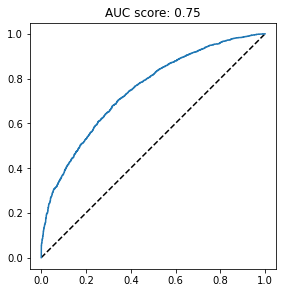

In [49]:
# Generar Curva ROC
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
pyplot.figure(figsize=(15,5))
ax = pyplot.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score: {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

In [50]:
from joblib import dump, load
dump(model, 'modelo_copa_america.joblib')

['modelo_copa_america.joblib']